In [68]:
import pandas as pd

# Load the dataset
file_path = 'Tapes/UoB_Set01_2025-01-02tapes.csv'  # Update this to the path of your CSV file
data = pd.read_csv(file_path, header=None, names=['seconds', 'transaction_price', 'number_of_transactions'])

# Convert seconds to a timedelta and then to a datetime starting from a reference point
data['timestamp'] = pd.to_timedelta(data['seconds'], unit='s') + pd.Timestamp('2025-01-02 00:00')
data.set_index(keys='timestamp', inplace=True)

# Resample the transaction prices to get mean values per second
resampled_data = data['transaction_price'].resample('1S').mean()

# Forward-fill the missing values
resampled_data_ffill = resampled_data.fillna(method='ffill').dropna()

split_point = int(len(resampled_data_ffill) * 0.8)
train_data = resampled_data_ffill[:split_point].asfreq('S')
test_data = resampled_data_ffill[split_point:].asfreq('S')

/var/folders/1f/gqtm7m2d6mq4y_35lmr6nxrc0000gn/T/ipykernel_42745/4113085582.py:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  resampled_data_ffill = resampled_data.fillna(method='ffill').dropna()


In [65]:
a = []
print(a)
a[0:] = [1,2,3,4,5,6,7,8,9,10]
print(a)


[]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195
200
205
210
215
220
225
230
235
240
245
250
255
260
265
270
275
280
285
290
295
300
305
310
315
320
325
330
335
340
345
350
355
360
365
370
375
380
385
390
395
400
405
410
415
420
425
430
435
440
445
450
455
460
465
470
475
480
485
490
495
500
505
510
515
520
525
530
535
540
545
550
555
560
565
570
575
580
585
590
595
600
605
610
615
620
625
630
635
640
645
650
655
660
665
670
675
680
685
690
695
700
705
710
715
720
725
730
735
740
745
750
755
760
765
770
775
780
785
790
795
800
805
810
815
820
825
830
835
840
845
850
855
860
865
870
875
880
885
890
895
900
905
910
915
920
925
930
935
940
945
950
955
960
965
970
975
980
985
990
995
1000
1005
1010
1015
1020
1025
1030
1035
1040
1045
1050
1055
1060
1065
1070
1075
1080
1085
1090
1095
1100
1105
1110
1115
1120
1125
1130
1135
1140
1145
1150
1155
1160
1165
1170
1175
1180
1185
1190
1195
1200
1205
1210
1215
12

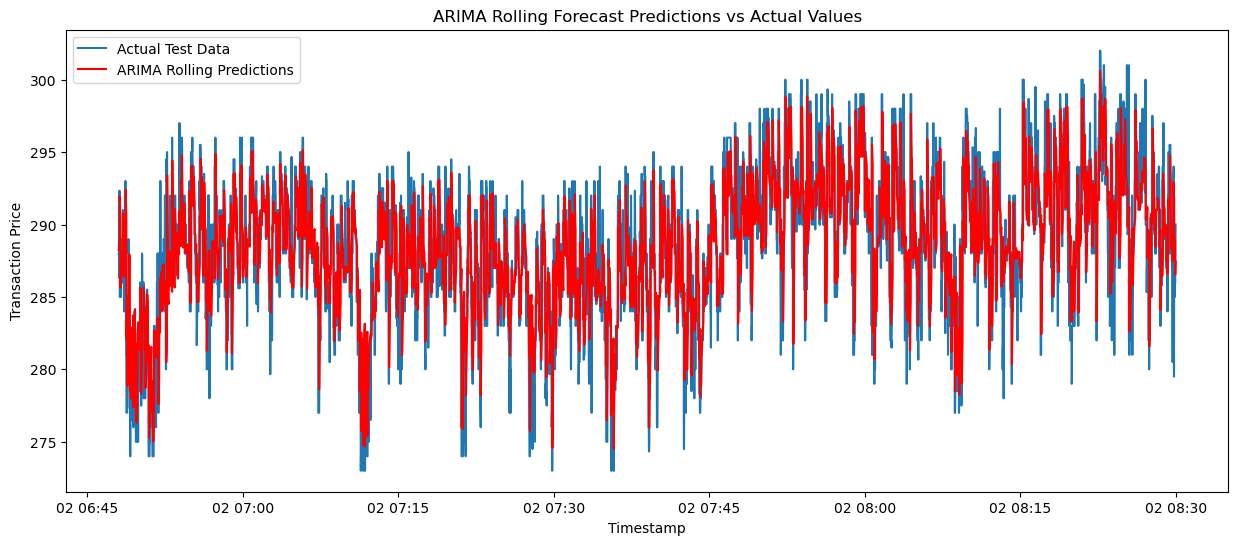

In [69]:
from statsmodels.tsa.arima.model import ARIMA

# Assuming train_data and test_data are pandas Series with datetime indices

# Set the frequency of the time series data
train_data = train_data.asfreq('S')
test_data = test_data.asfreq('S')

# Ensure the indices are monotonically increasing
train_data = train_data.sort_index()
test_data = test_data.sort_index()

# Check for duplicates and remove them if necessary
train_data = train_data[~train_data.index.duplicated(keep='first')]

# Define the frequency of model updates
update_frequency = 5  # Retrain the model every 5 steps

# Initialize the history with the training data
history = train_data.copy()

# Prepare a list to store predictions
predictions = []

# Preallocate the space for performance optimization
predictions = [None] * len(test_data)

# Start rolling forecast with updates every 5 steps
for t in range(0, len(test_data), update_frequency):
    # Fit the ARIMA model on the current history
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit()
    
    # Make predictions for the next 5 steps
    next_steps_predictions = model_fit.forecast(steps=update_frequency)
    
    # Store the predictions
    if t + update_frequency < len(test_data):
        predictions[t:t+update_frequency] = next_steps_predictions
    else:
        predictions[t:] = next_steps_predictions[:len(test_data)-t]
    
    # Update the history with the new observations
    if t + update_frequency < len(test_data):
        new_history = test_data[t:t+update_frequency]
        history = pd.concat([history, new_history])
    print(t)

print(len(predictions))
print(len(test_data.index))
# Convert predictions to a Series for easy plotting
predictions_series = pd.Series(predictions, index=test_data.index)

# Plotting the results
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.plot(test_data.index, test_data, label='Actual Test Data')
plt.plot(predictions_series.index, predictions_series, label='ARIMA Rolling Predictions', color='red')
plt.title('ARIMA Rolling Forecast Predictions vs Actual Values')
plt.xlabel('Timestamp')
plt.ylabel('Transaction Price')
plt.legend()
plt.show()



Below code are still in progress, and it's aimed to try out with different parameters i.e. order of the ARIMA model to see any performance difference.

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Initial model: ARIMA(1,1,1)
model = ARIMA(train_data, order=(5, 1, 1))
model_fit = model.fit()


In [ ]:
predictions = model_fit.forecast(steps=len(test_data))
print(predictions[:50])

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np

plt.figure(figsize=(15, 6))
plt.plot(train_data.index[-50:], train_data[-50:], label='Training Data (Last 50 Points)')
plt.plot(test_data.index, test_data, label='Actual Test Data')
plt.plot(test_data.index, predictions, label='ARIMA Predictions', color='red')
plt.title('ARIMA Model Predictions vs Actual Values')
plt.xlabel('Timestamp')
plt.ylabel('Transaction Price')
plt.legend()
plt.show()

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_data, predictions))
print(f"Root Mean Squared Error (RMSE) of Predictions: {rmse}")
